In [1]:
from __future__ import print_function

import argparse
import os
import shutil
import time
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import models_analysis.cifar as models

from utils import Bar, Logger, AverageMeter, accuracy, mkdir_p, savefig
from utils.radam import RAdam, AdamW
from optimizers.sgd_adaptive3 import *
from optimizers.SRAdamW import *
from optimizers.SRRAdam import *

from tensorboardX import SummaryWriter

from IPython.core.debugger import Tracer

In [2]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

In [3]:
class Options:
    def __init__(self):
        # Datasets
        self.dataset = 'cifar10'
        self.workers = 4
        # Optimization options
        self.train_batch = 128
        self.test_batch = 20
        # Checkpoints
        self.checkpoint = 'momentum-analysis'
        #self.resume = '/tanresults/experiments-restarting/cifar10-preresnet_v2290-bottleneck-wd-5e-4-sgd-lr-0-1-gamma-0-1-lrdrop3-scheme1-n-50-seed-0/model_best.pth.tar'
        self.resume = '/tanresults3/experiments-momentum/cifar10-momentumnet_learned_scalar290-bottleneck--wd-5e-4-sgd-lr-0-1-gamma-0-1-stepsize-2.0-mom-0.1-seed-0/model_best.pth.tar'
        #self.resume = '/tanstorage/results_restarting/cifar10-preresnet290-bottleneck-wd-5e-4-sgd-lr-0-1-gamma-0-1-lrdrop3-scheme1-n-50-seed-0/model_best.pth.tar'
        # Architecture
        self.arch = 'momentumnet_learned_scalar'
        #self.arch = 'preresnet'
        #self.arch = 'preresnet_v2'
        self.depth = 290
        self.block_name = "bottleneck"
        self.gpu_id = '1'
        # Momentum
        self.step_size = 2.0
        self.momentum_const = 0.1
        self.feature_vec = 'x'
        
args = Options()
# Use CUDA
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu_id
use_cuda = torch.cuda.is_available()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

if args.dataset == 'cifar10':
    dataloader = datasets.CIFAR10
    num_classes = 10
else:
    dataloader = datasets.CIFAR100
    num_classes = 100


trainset = dataloader(root='./data', train=True, download=True, transform=transform_train)
trainloader = data.DataLoader(trainset, batch_size=args.train_batch, shuffle=True, num_workers=args.workers)

testset = dataloader(root='./data', train=False, download=False, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=args.test_batch, shuffle=False, num_workers=args.workers)

Files already downloaded and verified


In [5]:
# Model
print("==> creating model '{}'".format(args.arch))

criterion = nn.CrossEntropyLoss()

if args.arch.startswith('resnext'):
    model = models.__dict__[args.arch](
                cardinality=args.cardinality,
                num_classes=num_classes,
                depth=args.depth,
                widen_factor=args.widen_factor,
                dropRate=args.drop,
            )
elif args.arch.startswith('densenet'):
    model = models.__dict__[args.arch](
                num_classes=num_classes,
                depth=args.depth,
                growthRate=args.growthRate,
                compressionRate=args.compressionRate,
                dropRate=args.drop,
            )
elif args.arch.startswith('wrn'):
    model = models.__dict__[args.arch](
                num_classes=num_classes,
                depth=args.depth,
                widen_factor=args.widen_factor,
                dropRate=args.drop,
            )
elif args.arch.startswith('resnet'):
    model = models.__dict__[args.arch](
                num_classes=num_classes,
                depth=args.depth,
                block_name=args.block_name,
            )
elif args.arch.startswith('preresnet'):
    model = models.__dict__[args.arch](
                num_classes=num_classes,
                depth=args.depth,
                block_name=args.block_name,
            )
elif args.arch.startswith('horesnet'):
    model = models.__dict__[args.arch](
                num_classes=num_classes,
                depth=args.depth,
                eta=args.eta,
                block_name=args.block_name,
                feature_vec=args.feature_vec
            )
elif args.arch.startswith('hopreresnet'):
    model = models.__dict__[args.arch](
                num_classes=num_classes,
                depth=args.depth,
                eta=args.eta,
                block_name=args.block_name,
                feature_vec=args.feature_vec
            )
elif args.arch.startswith('nagpreresnet'):
    model = models.__dict__[args.arch](
                num_classes=num_classes,
                depth=args.depth,
                eta=args.eta,
                block_name=args.block_name,
                feature_vec=args.feature_vec
            )
elif args.arch.startswith('mompreresnet'):
    model = models.__dict__[args.arch](
                num_classes=num_classes,
                depth=args.depth,
                eta=args.eta,
                block_name=args.block_name,
                feature_vec=args.feature_vec
            )
elif args.arch.startswith('momentumnet'):
    model = models.__dict__[args.arch](
                num_classes=num_classes,
                depth=args.depth,
                step_size=args.step_size, 
                momentum=args.momentum_const,
                block_name=args.block_name,
                feature_vec=args.feature_vec
            )
elif args.arch.startswith('v2_preresnet'):
    if args.depth == 18:
        block_name = 'basicblock'
        num_blocks=[2,2,2,2]
    elif args.depth == 34:
        block_name = 'basicblock'
        num_blocks=[3,4,6,3]
    elif args.depth == 50:
        block_name = 'bottleneck'
        num_blocks=[3,4,6,3]
    elif args.depth == 101:
        block_name = 'bottleneck'
        num_blocks=[3,4,23,3]
    elif args.depth == 152:
        block_name = 'bottleneck'
        num_blocks=[3,8,36,3]

    model = models.__dict__[args.arch](
                block_name=block_name, 
                num_blocks=num_blocks, 
                num_classes=num_classes
            )
else:
    print('Model is specified wrongly - Use standard model')
    model = models.__dict__[args.arch](num_classes=num_classes)

model = torch.nn.DataParallel(model).cuda()
cudnn.benchmark = True
print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

==> creating model 'momentumnet_learned_scalar'
    Total params: 3.00M


In [6]:
# Load checkpoint.
print('==> Resuming from checkpoint..')
assert os.path.isfile(args.resume), 'Error: no checkpoint directory found!'
checkpoint = torch.load(args.resume)
best_acc = checkpoint['best_acc']
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['state_dict'])

==> Resuming from checkpoint..


<All keys matched successfully>

In [7]:
def test(testloader, model, criterion, epoch, use_cuda):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar('Processing', max=len(testloader))
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '(Epoch {epoch}, {batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    epoch=epoch,
                    batch=batch_idx + 1,
                    size=len(testloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    )
        bar.next()
    bar.finish()
    return (losses.avg, top1.avg)

In [8]:
print('\nEvaluation only')
test_loss, test_acc = test(trainloader, model, criterion, start_epoch, use_cuda)
print(' Test Loss:  %.8f, Test Acc:  %.2f' % (test_loss, test_acc))


Evaluation only


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


 Test Loss:  0.00156841, Test Acc:  100.00


In [9]:
norms = model.module.get_norm()
nblocks = len(norms)
for i in range(nblocks):
    norms[i] = norms[i].cpu().numpy()
np.save('./norms_momentum.npy',norms)

number of blocks = 96


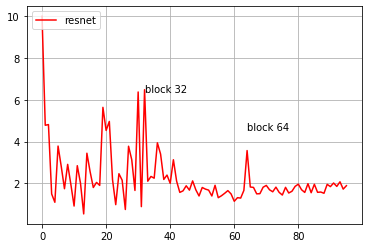

In [13]:
norms_mom = np.load('./norms_momentum.npy')
norms_res = np.load('./norms_resnet.npy')
norms_res_v2 = np.load('./norms_resnet_v2.npy')
nblocks = len(norms_mom)
print('number of blocks = %i'%nblocks)
blockid = list(range(nblocks))

fig, ax = plt.subplots()
# ax.plot(m, acc_x_vx, label='use x, v0=x')
# ax.plot(m, acc_v_vx, label='use v, v0=x')
#ax.plot(blockid, norms_mom, 'b-', label='momentumnet')
ax.plot(blockid, norms_res, 'r-', label='resnet')
#ax.plot(blockid, norms_res_v2, 'g-', label='resnet_v2')
for i,j in zip(blockid, norms_mom):
    if i in [32, 64]:
        ax.annotate(str('block %i'%i),xy=(i,j))
#ax.plot(m, acc_v_v0, '-o', label='use v, v0=0')
ax.grid()
ax.legend(loc='upper left')
fig.show()
fig.savefig('./figures/norm_acts_3.pdf')

In [ ]:
import json

In [ ]:
def get_tensorboard_val(filename):
    with open(filename) as jfile:
        dat = json.load(jfile)
    epochs = []
    vals = []
    for i in range(len(dat)):
        epochs.append(dat[i][1])
        vals.append(dat[i][2])
    return epochs, vals

In [ ]:
filename_mom = './run-momentumnet_train_loss_momentumnet_learned_scalar-tag-train_loss.json'
filename_res = './run-resnet_train_loss_preresnet20_srsgd-tag-train_loss.json'

epochs, vals_res = get_tensorboard_val(filename_res)
epochs, vals_mom = get_tensorboard_val(filename_mom)

epochs = epochs[-199:]
vals_mom = vals_mom[-199:]
vals_res = vals_res[-199:]

fig, ax = plt.subplots()
# ax.plot(m, acc_x_vx, label='use x, v0=x')
# ax.plot(m, acc_v_vx, label='use v, v0=x')
ax.plot(epochs, vals_mom, 'b-', label='momentumnet')
ax.plot(epochs, vals_res, 'r-', label='resnet')
ax.set(yscale="log")
#ax.plot(m, acc_v_v0, '-o', label='use v, v0=0')
ax.grid()
ax.legend(loc='upper left')
fig.show()
fig.savefig('./figures/train_loss_momentumnet.pdf')

In [ ]:
filename_mom = './run-momentumnet_test_acc_momentumnet_learned_scalar-tag-test_acc.json'
filename_res = './run-resnet_test_acc_preresnet20_srsgd-tag-test_acc.json'

epochs, vals_res = get_tensorboard_val(filename_res)
epochs, vals_mom = get_tensorboard_val(filename_mom)

epochs = epochs[-199::]
vals_mom = vals_mom[-199::]
vals_res = vals_res[-199::]

fig, ax = plt.subplots()
# ax.plot(m, acc_x_vx, label='use x, v0=x')
# ax.plot(m, acc_v_vx, label='use v, v0=x')
ax.plot(epochs, vals_mom, 'b-', label='momentumnet')
ax.plot(epochs, vals_res, 'r-', label='resnet')
#ax.set(yscale="log")
#ax.plot(m, acc_v_v0, '-o', label='use v, v0=0')
ax.grid()
ax.legend(loc='upper left')
fig.show()
fig.savefig('./figures/test_acc_momentumnet.pdf')

In [ ]:
filename_srsgd = './run-cifar10_resnet290_srsgd_lin_0_train_loss_preresnet20_srsgd-tag-train_loss.json'
filename_sgd = './run-resnet_train_loss_preresnet20_srsgd-tag-train_loss.json'

epochs, vals_sgd = get_tensorboard_val(filename_sgd)
epochs, vals_srsgd = get_tensorboard_val(filename_srsgd)

epochs = epochs[-199:]
vals_srsgd = vals_srsgd[-199:]
vals_sgd = vals_sgd[-199:]

fig, ax = plt.subplots()
# ax.plot(m, acc_x_vx, label='use x, v0=x')
# ax.plot(m, acc_v_vx, label='use v, v0=x')
ax.plot(epochs, vals_srsgd, 'b-', label='SRSGD')
ax.plot(epochs, vals_sgd, 'r-', label='SGD')
ax.set(yscale="log")
#ax.plot(m, acc_v_v0, '-o', label='use v, v0=0')
ax.grid()
ax.legend(loc='upper left')
fig.show()
fig.savefig('./figures/train_loss_srsgd.pdf')

In [ ]:
filename_srsgd = './run-imagenet_resnet101_const_40_srsgd_0_train_loss_resnet101_srsgd-tag-train_loss.json'
filename_sgd = './run-imagenet_resnet101_basline_sgd_0_train_loss_resnet101_srsgd-tag-train_loss.json'

epochs, vals_sgd = get_tensorboard_val(filename_sgd)
epochs, vals_srsgd = get_tensorboard_val(filename_srsgd)

epochs = epochs[-89:]
vals_srsgd = vals_srsgd[-89:]
vals_sgd = vals_sgd[-89:]

fig, ax = plt.subplots()
# ax.plot(m, acc_x_vx, label='use x, v0=x')
# ax.plot(m, acc_v_vx, label='use v, v0=x')
ax.plot(epochs, vals_srsgd, 'b-', label='SRSGD')
ax.plot(epochs, vals_sgd, 'r-', label='SGD')
ax.set(yscale="log")
#ax.plot(m, acc_v_v0, '-o', label='use v, v0=0')
ax.grid()
ax.legend(loc='upper left')
fig.show()
fig.savefig('./figures/train_loss_srsgd_imagenet.pdf')

In [ ]:
filename_srsgd = './run-iwslt14_srsgd_N_700_fixed_decay_lr_0_003_0_valid-tag-ppl.json'
filename_sgd = './run-iwslt14_nag_fixed_decay_lr_0_003_0_valid-tag-ppl.json'
filename_adam = './run-iwslt14_basline_0_valid-tag-ppl.json'

epochs, vals_adam = get_tensorboard_val(filename_adam)
epochs, vals_sgd = get_tensorboard_val(filename_sgd)
epochs, vals_srsgd = get_tensorboard_val(filename_srsgd)

# epochs = epochs[-89:]
# vals_srsgd = vals_srsgd[-89:]
# vals_sgd = vals_sgd[-89:]

fig, ax = plt.subplots()
# ax.plot(m, acc_x_vx, label='use x, v0=x')
# ax.plot(m, acc_v_vx, label='use v, v0=x')
ax.plot(epochs, vals_srsgd, 'b-', label='SRSGD')
ax.plot(epochs, vals_sgd, 'r-', label='SGD')
ax.plot(epochs, vals_adam, 'g-', label='Adam')
ax.set(yscale="log")
#ax.plot(m, acc_v_v0, '-o', label='use v, v0=0')
ax.grid()
ax.legend(loc='upper left')
fig.show()
fig.savefig('./figures/val_ppl_srsgd_nmt.pdf')

In [ ]:
filename_srsgd = './run-iwslt14_srsgd_N_700_fixed_decay_lr_0_003_0_train-tag-loss.json'
filename_sgd = './run-iwslt14_nag_fixed_decay_lr_0_003_0_train-tag-loss.json'
filename_adam = './run-iwslt14_basline_0_train-tag-loss.json'

epochs, vals_adam = get_tensorboard_val(filename_adam)
epochs, vals_sgd = get_tensorboard_val(filename_sgd)
epochs, vals_srsgd = get_tensorboard_val(filename_srsgd)

# epochs = epochs[-89:]
# vals_srsgd = vals_srsgd[-89:]
# vals_sgd = vals_sgd[-89:]

fig, ax = plt.subplots()
# ax.plot(m, acc_x_vx, label='use x, v0=x')
# ax.plot(m, acc_v_vx, label='use v, v0=x')
ax.plot(epochs, vals_srsgd, 'b-', label='SRSGD')
ax.plot(epochs, vals_sgd, 'r-', label='SGD')
ax.plot(epochs, vals_adam, 'g-', label='Adam')
ax.set(yscale="log")
#ax.plot(m, acc_v_v0, '-o', label='use v, v0=0')
ax.grid()
ax.legend(loc='upper left')
fig.show()
fig.savefig('./figures/train_loss_srsgd_nmt.pdf')

In [ ]:
filename_sgd = './run-cifar10_preresnet1001_sgd_baseline_0_test_acc_preresnet20_srsgd-tag-test_acc.json'
filename_srsgd_lin = './run-cifar10_preresnet1001_srsgd_lin_0_test_acc_preresnet20_srsgd-tag-test_acc.json'
filename_srsgd_exp = './run-cifar10_preresnet1001_srsgd_exp_0_test_acc_preresnet20_srsgd-tag-test_acc.json'

epochs, vals_sgd = get_tensorboard_val(filename_sgd)
epochs, vals_srsgd_lin = get_tensorboard_val(filename_srsgd_lin)
epochs, vals_srsgd_exp = get_tensorboard_val(filename_srsgd_exp)

epochs = epochs[:49]
vals_srsgd_lin = vals_srsgd_lin[:49]
vals_srsgd_exp = vals_srsgd_exp[:49]
vals_sgd = vals_sgd[:49]

fig, ax = plt.subplots()
# ax.plot(m, acc_x_vx, label='use x, v0=x')
# ax.plot(m, acc_v_vx, label='use v, v0=x')
ax.plot(epochs, vals_srsgd_lin, 'b-', label='SRSGD-linear')
ax.plot(epochs, vals_sgd, 'r-', label='SGD')
ax.plot(epochs, vals_srsgd_exp, 'g-', label='SRSGD-exponential')
#ax.set(yscale="log")
# ax.set_xlim(left=20)
# ax.set_ylim(bottom=90)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
#ax.plot(m, acc_v_v0, '-o', label='use v, v0=0')
ax.grid()
ax.legend(loc='lower right')
fig.show()
fig.savefig('./figures/test_acc_srsgd_short_cifar10.pdf')

In [ ]:
filename_sgd = './run-cifar100_preresnet1001_sgd_baseline_0_test_acc_preresnet20_srsgd-tag-test_acc.json'
filename_srsgd_lin = './run-cifar100_preresnet1001_srsgd_lin_0_test_acc_preresnet20_srsgd-tag-test_acc.json'
filename_srsgd_exp = './run-cifar100_preresnet1001_srsgd_exp_0_test_acc_preresnet20_srsgd-tag-test_acc.json'

epochs, vals_sgd = get_tensorboard_val(filename_sgd)
epochs, vals_srsgd_lin = get_tensorboard_val(filename_srsgd_lin)
epochs, vals_srsgd_exp = get_tensorboard_val(filename_srsgd_exp)

epochs = epochs[:49]
vals_srsgd_lin = vals_srsgd_lin[:49]
vals_srsgd_exp = vals_srsgd_exp[:49]
vals_sgd = vals_sgd[:49]

fig, ax = plt.subplots()
# ax.plot(m, acc_x_vx, label='use x, v0=x')
# ax.plot(m, acc_v_vx, label='use v, v0=x')
ax.plot(epochs, vals_srsgd_lin, 'b-', label='SRSGD-linear')
ax.plot(epochs, vals_sgd, 'r-', label='SGD')
ax.plot(epochs, vals_srsgd_exp, 'g-', label='SRSGD-exponential')
#ax.set(yscale="log")
ax.set_xlim(left=20)
ax.set_ylim(bottom=60)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
#ax.plot(m, acc_v_v0, '-o', label='use v, v0=0')
ax.grid()
ax.legend(loc='lower right')
fig.show()
fig.savefig('./figures/test_acc_srsgd_short_cifar100_zoomin.pdf')